In [1]:
import logging
from utility import add_project_root_to_path

logging.basicConfig(level=logging.ERROR)

add_project_root_to_path()

In [2]:
# Building experiments configs

from experiments.configs import DATA_SOURCE_BY_ALIAS, DEFAULT_UNINFORMED_USERS_CONFIG
from experiments.experiment import Experiment
from user.informed_user import InformedUser

from fee_algorithm.fixed_fee import FixedFee
from fee_algorithm.discrete_fee_perfect_oracle import DiscreteFeePerfectOracle
# from fee_algorithm.continuous_fee_perfect_oracle import ContinuousFeePerfectOracle
# from fee_algorithm.fee_based_on_historical_price import FeeBasedOnHistoricalPrice
from fee_algorithm.based_on_trade_count_fee import BasedOnTradeCountFee
from fee_algorithm.adaptive_fee_based_on_block_price_move import AdaptiveBasedOnPreviousBlockPriceMoveFee
from experiments.run_multiple_experiments import run_multiple_experiments, get_experiment_key


from copy import deepcopy

fee_algos_to_consider = {
    "fixed_fee": FixedFee(exchange_fee_rate=0.003), # 30 bps
    "based_on_trade_count_fee": BasedOnTradeCountFee(a_to_b_exchange_fee_rate=0.003, b_to_a_exchange_fee_rate=0.003), # 30 bps
    "adaptive_based_on_previous_block_price_move_fee": AdaptiveBasedOnPreviousBlockPriceMoveFee(a_to_b_exchange_fee_rate=0.003, b_to_a_exchange_fee_rate=0.003), # 30 bps
    "discrete_fee_perfect_oracle": DiscreteFeePerfectOracle(fee_rate_in_arbitrage_direction=0.0045, fee_rate_in_non_arbitrage_direction=0.0015), # 45/15 bps
    # "continuous_fee_perfect_oracle": ContinuousFeePerfectOracle(default_fee_rate=0.003), # 30 bps
    # "fee_based_on_historical_price": FeeBasedOnHistoricalPrice(alpha=0.3, fee_in_increasing_deviation_direction=0.0045, fee_in_decreasing_deviation_direction=0.0015), # 45/15 bps
}

experiment_configs = {}


for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    data_source = DATA_SOURCE_BY_ALIAS[period_alias]
    for fee_algo_alias, fee_algo in fee_algos_to_consider.items():
        experiment_configs[
            get_experiment_key(
                {
                    "period_alias": period_alias,
                    "fee_algorithm": fee_algo_alias,
                }
            )
        ] = Experiment(
            data=data_source,
            fee_algorithm=deepcopy(fee_algo),
            uninformed_users=deepcopy(DEFAULT_UNINFORMED_USERS_CONFIG),
            informed_user=InformedUser(),
        )

In [3]:
from pprint import pprint

pprint(experiment_configs[
    get_experiment_key(
        {
        "period_alias": "volatile_market",
        "fee_algorithm": "fixed_fee",
    })
])

Experiment(data=HistoricalDataDescription(start_time=datetime.datetime(2024, 3, 1, 12, 0),
                                          end_time=datetime.datetime(2024, 3, 31, 12, 0),
                                          A_symbol='ETH',
                                          B_symbol='SHIB',
                                          stable_coin_symbol='USDT',
                                          candle_interval='1m'),
           fee_algorithm=FixedFee(exchange_fee_rate=0.003),
           informed_user=InformedUser(),
           uninformed_users=UninformedUsersConfig(uninformed_user=UninformedUser(mu=0.00016,
                                                                                 sigma=1e-05),
                                                  probability_of_trade=0.5,
                                                  n_users=1),
           initial_pool_value=25000000,
           network_fee=5,
           random_seed=0)


In [4]:
print(
    f"Total experiments to run: {len(experiment_configs)}"
)

Total experiments to run: 16


In [5]:
experiment_results = run_multiple_experiments(
    experiments=experiment_configs,
    parallel=True,
    max_workers=16,
)

Running Experiments: 100%|██████████| 16/16 [01:11<00:00,  4.44s/it]


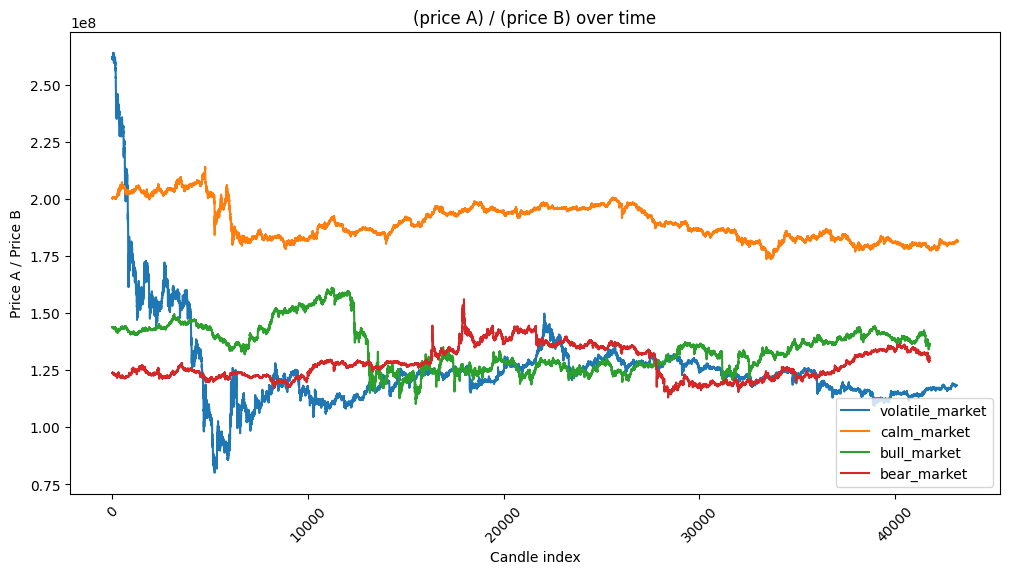

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    experiment_result = experiment_results[
        get_experiment_key(
            {
                "period_alias": period_alias,
                "fee_algorithm": "fixed_fee",
            }
        )
    ]
    plt.plot(experiment_result.data["price_A"] / experiment_result.data["price_B"], label=period_alias)
    plt.title("(price A) / (price B) over time")

plt.ylabel("Price A / Price B")
plt.xlabel("Candle index")
# plt.yscale("log")

plt.xticks(rotation=45)

plt.legend(loc="lower right")

plt.show()

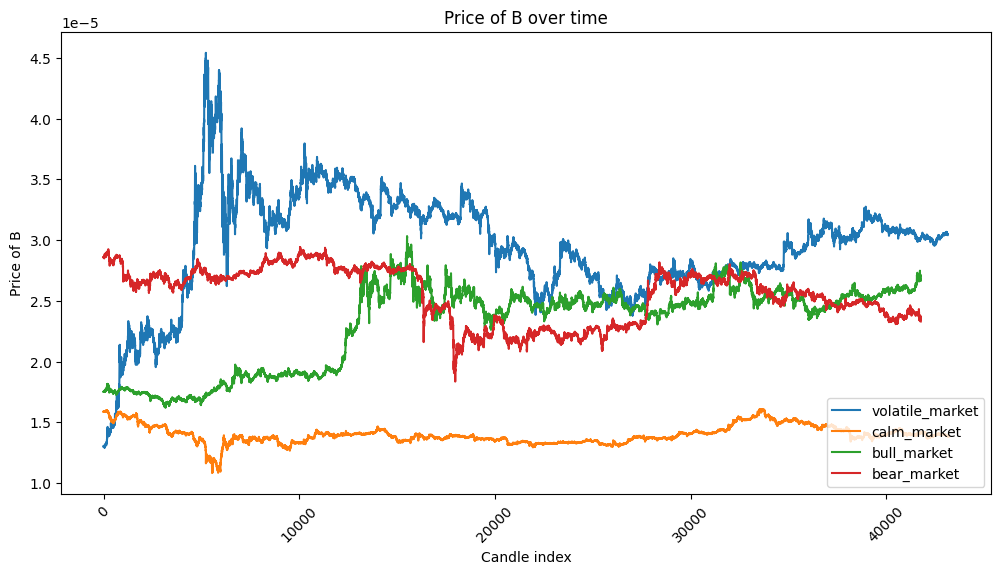

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    experiment_result = experiment_results[
        get_experiment_key(
            {
                "period_alias": period_alias,
                "fee_algorithm": "fixed_fee",
            }
        )
    ]
    plt.plot(experiment_result.data["price_B"], label=period_alias)
    plt.title("Price of B over time")

plt.ylabel("Price of B")
plt.xlabel("Candle index")
# plt.yscale("log")

plt.xticks(rotation=45)

plt.legend(loc="lower right")

plt.show()

### Results

In [8]:
from visualizations.compare_fee_algoritms import plot_participants_markouts, plot_impermanent_loss, get_experiments_summary_by_alias

In [9]:
def plot_results_for_period(period_alias: str, fee_algos_to_consider: list[str]):
    map_by_fee_algo = {
        fee_algo_alias: experiment_results[
            get_experiment_key(
                {
                    "period_alias": period_alias,
                    "fee_algorithm": fee_algo_alias,
                }
            )
        ]
        for fee_algo_alias in fee_algos_to_consider
    }
    plot_participants_markouts(
        period_alias,
        map_by_fee_algo,
    )
    plot_impermanent_loss(
        period_alias,
        map_by_fee_algo,
    )

    summary = get_experiments_summary_by_alias(
        map_by_fee_algo
    )

    display(summary)

### Results for bull market

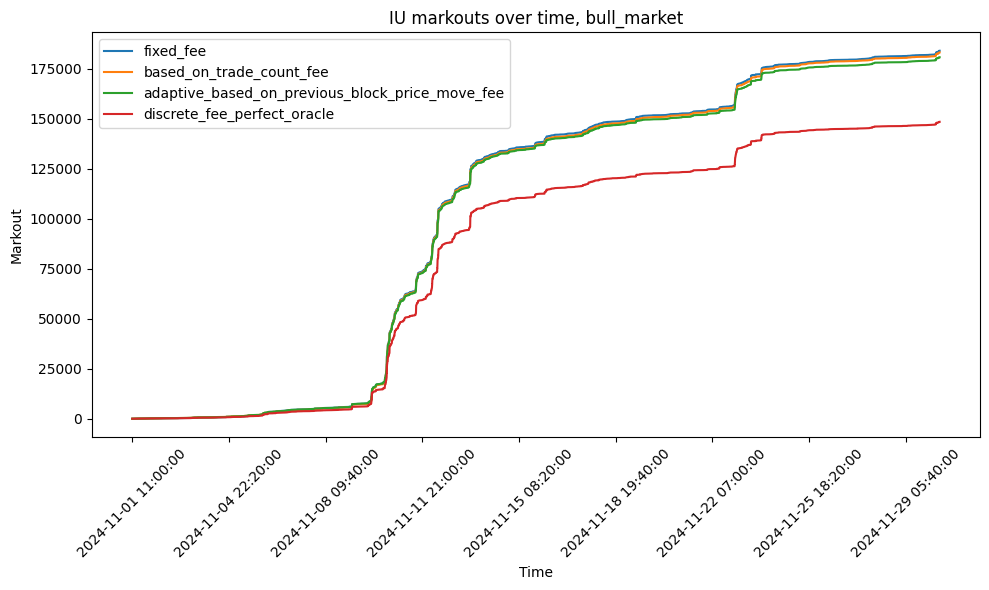

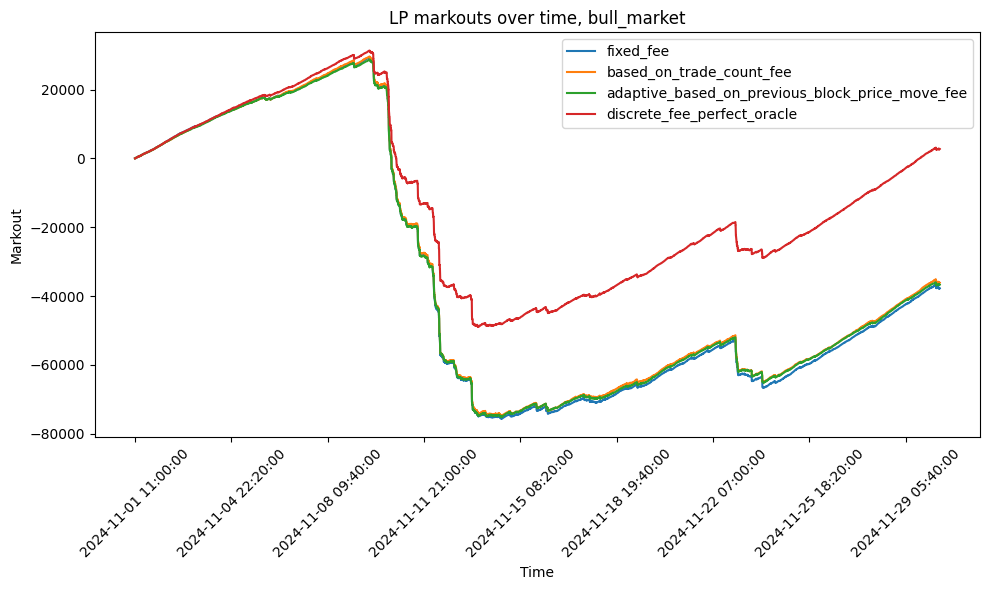

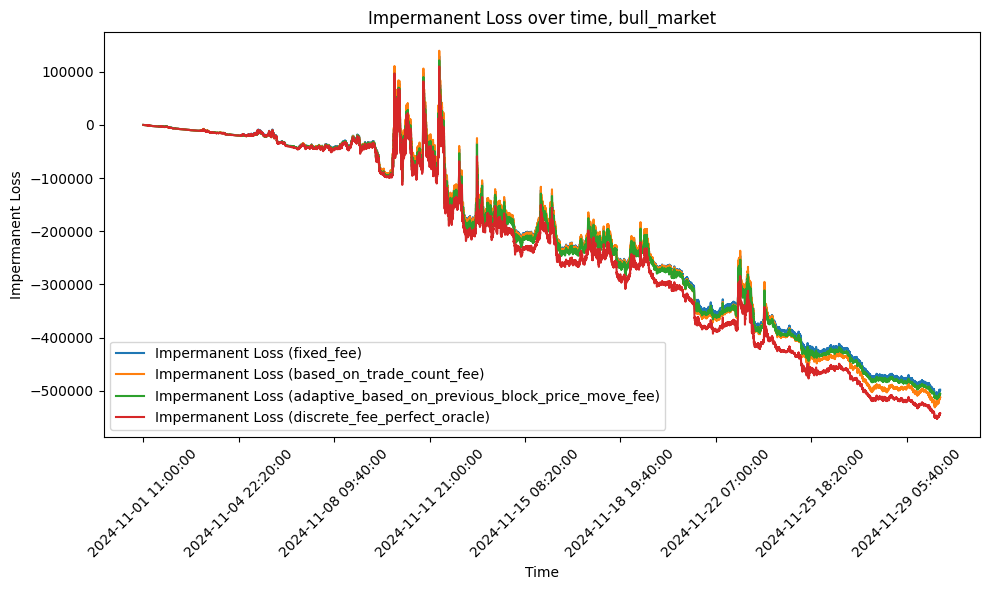

,experiment_name,iu_markout,iu_trade_count,uu_markout,uu_trade_count,lp_markout,impermanent_loss
0,fixed_fee,183885.20,4459,-272719.97,20864,-37780.23,-497942.00
1,based_on_trade_count_fee,183091.02,4410,-273177.16,20837,-36148.86,-512479.41
2,adaptive_based_on_previous_block_price_move_fee,180638.61,4392,-269787.73,20782,-36720.88,-505209.70
3,discrete_fee_perfect_oracle,148359.50,3243,-271359.24,20813,2719.73,-541722.54


In [10]:
bull_market_summary = plot_results_for_period("bull_market", list(fee_algos_to_consider.keys()))

### Results for calm market

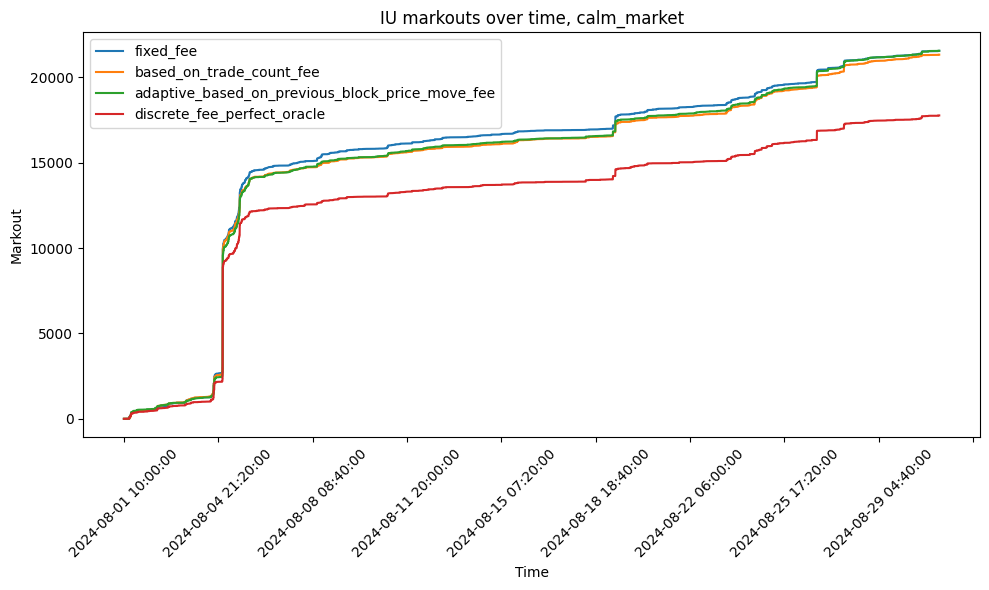

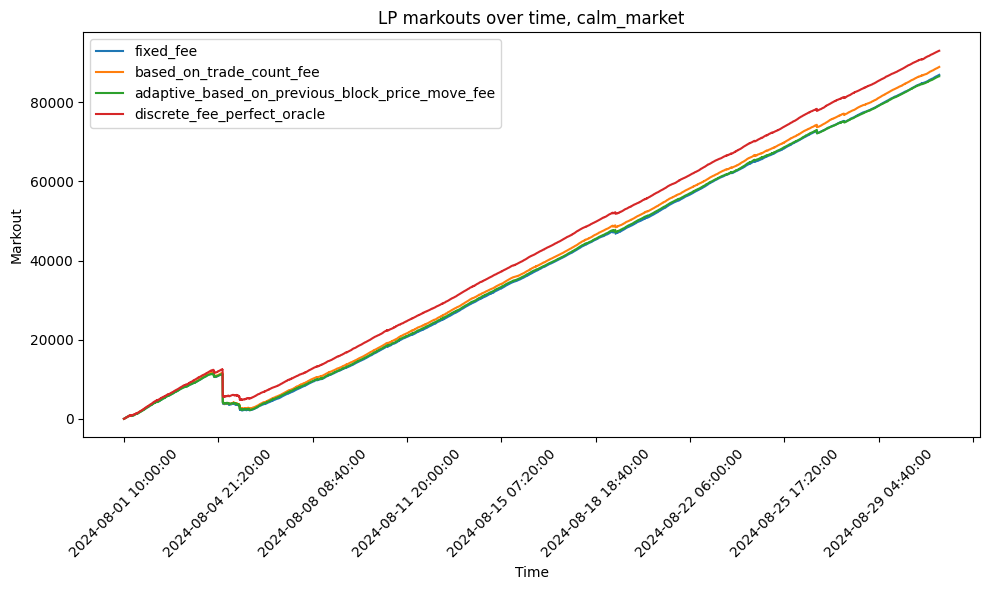

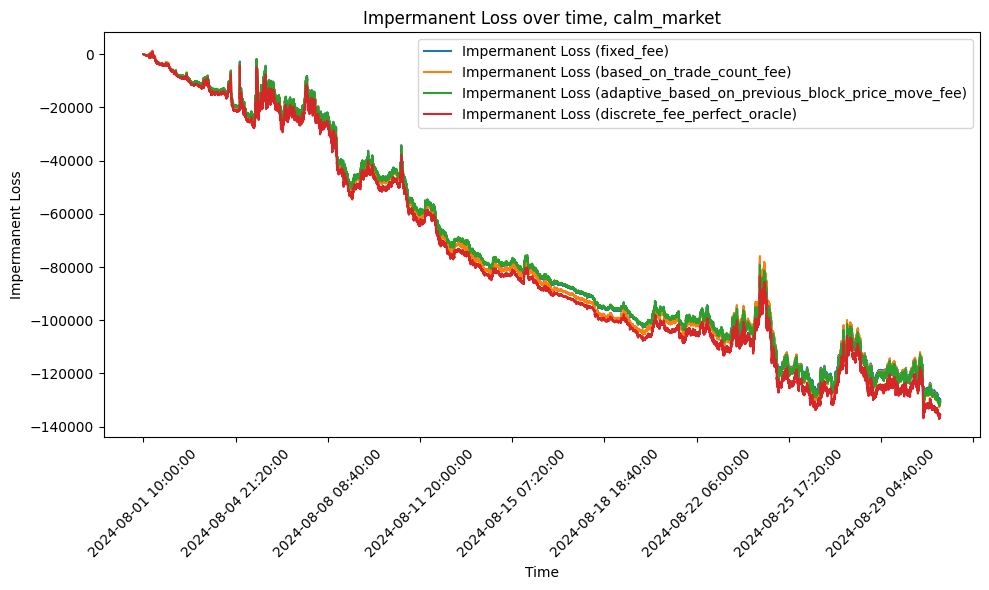

,experiment_name,iu_markout,iu_trade_count,uu_markout,uu_trade_count,lp_markout,impermanent_loss
0,fixed_fee,21547.33,1388,-222801.41,21478,86924.08,-129736.31
1,based_on_trade_count_fee,21326.49,1386,-224479.16,21460,88922.67,-130708.31
2,adaptive_based_on_previous_block_price_move_fee,21556.81,1449,-222935.93,21510,86584.12,-130465.17
3,discrete_fee_perfect_oracle,17768.01,1016,-223127.23,21453,93014.22,-135422.48


In [11]:
calm_market_summary = plot_results_for_period("calm_market", list(fee_algos_to_consider.keys()))

### Results for bear market

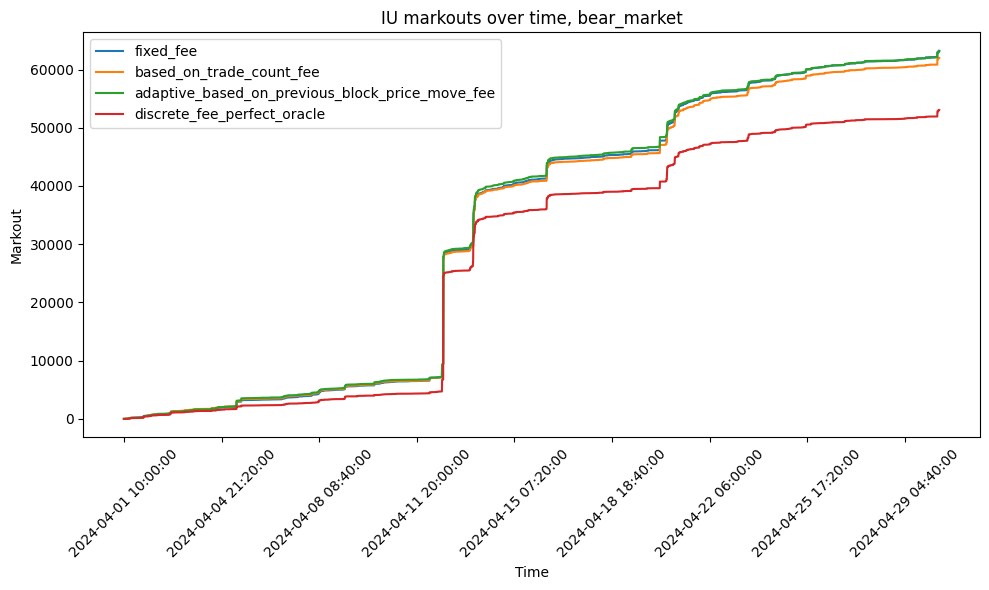

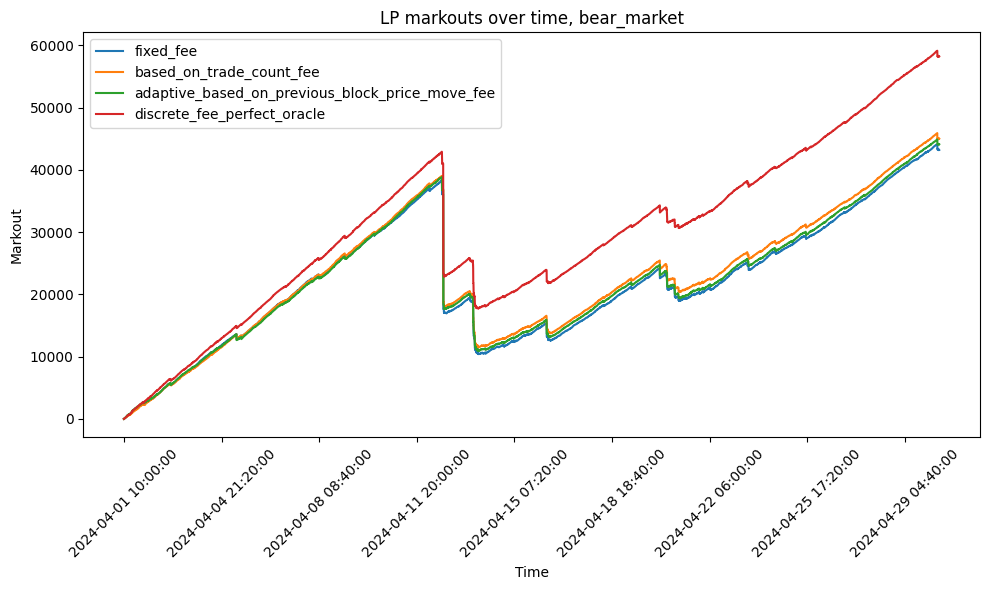

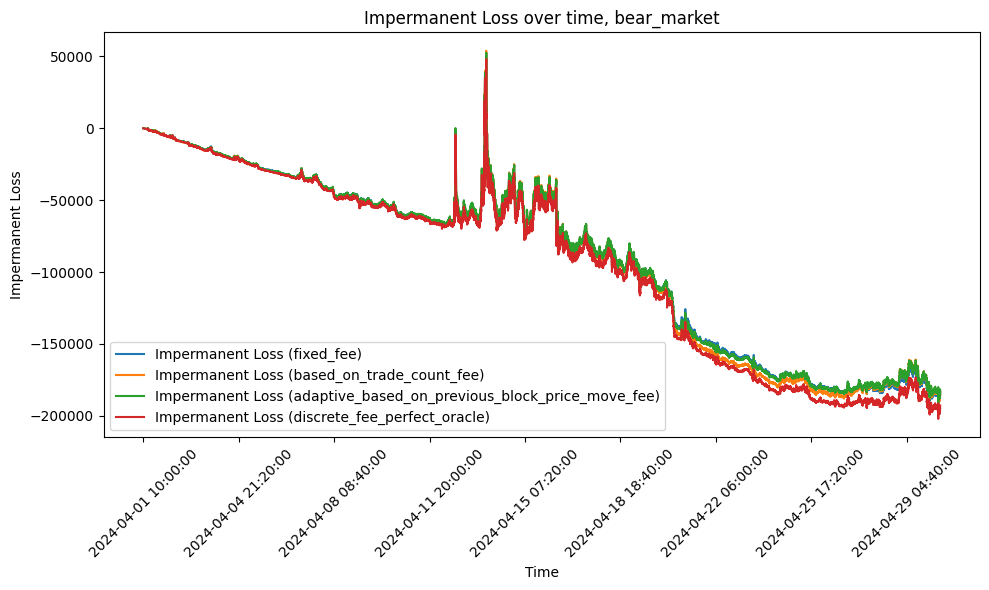

,experiment_name,iu_markout,iu_trade_count,uu_markout,uu_trade_count,lp_markout,impermanent_loss
0,fixed_fee,63221.84,2199,-221016.89,20718,43210.05,-183518.44
1,based_on_trade_count_fee,61989.66,2195,-222020.00,20811,45000.34,-182912.90
2,adaptive_based_on_previous_block_price_move_fee,63081.51,2208,-222167.81,20784,44126.30,-181757.01
3,discrete_fee_perfect_oracle,53033.05,1538,-222756.76,20756,58253.71,-192817.69


In [12]:
bear_market_summary = plot_results_for_period("bear_market", list(fee_algos_to_consider.keys()))

### Results for volatile market

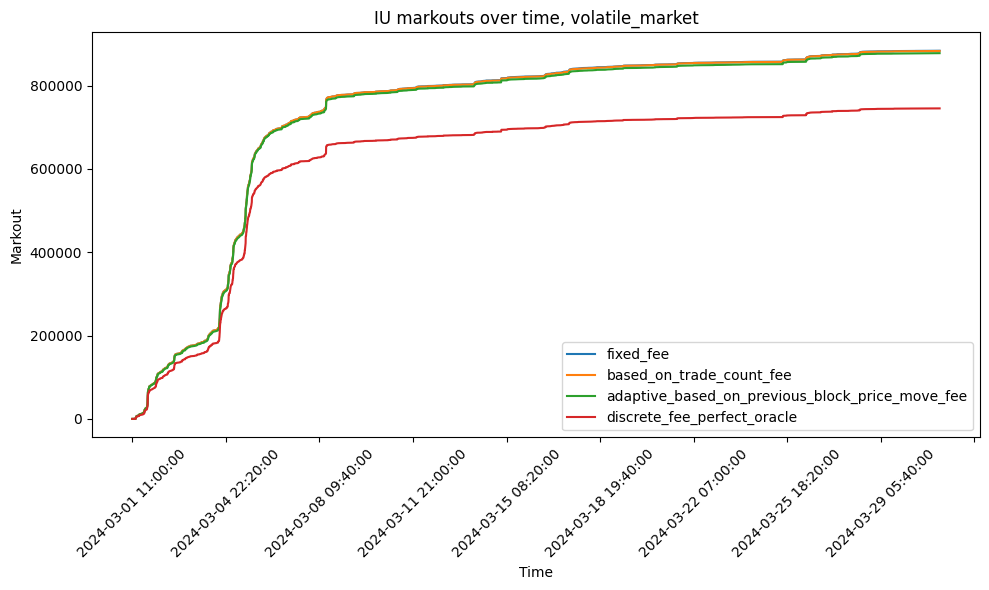

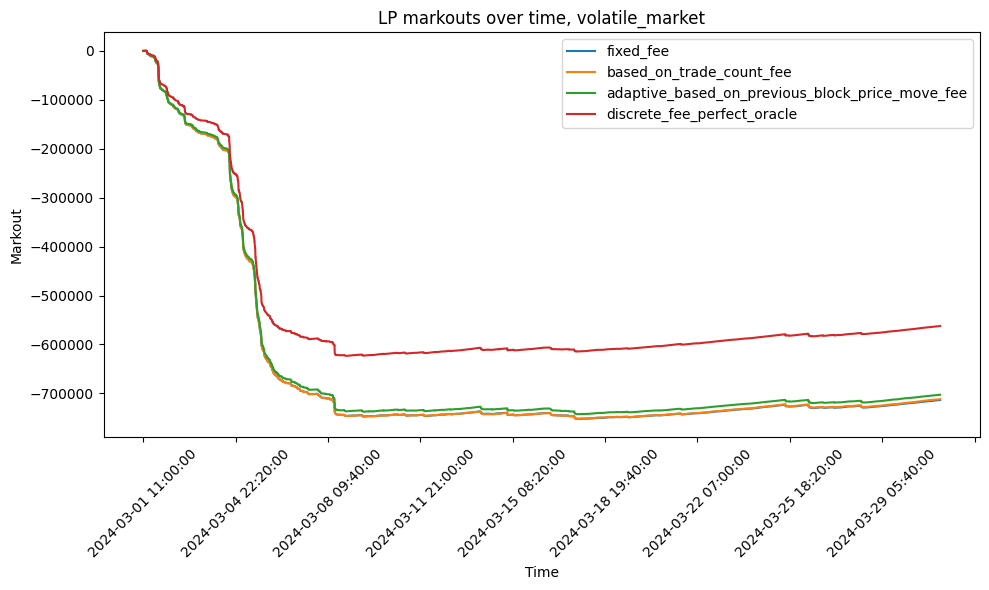

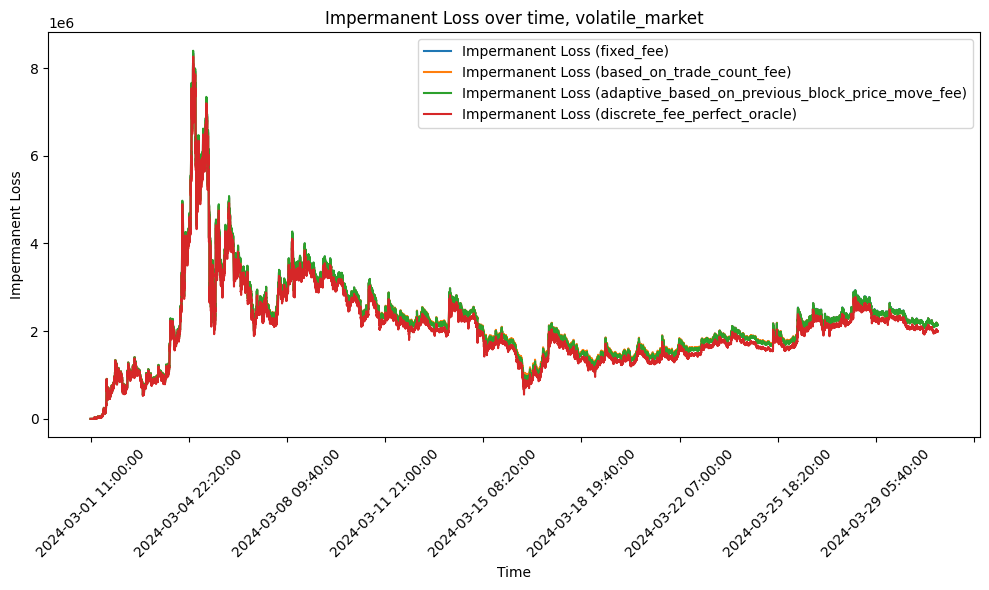

,experiment_name,iu_markout,iu_trade_count,uu_markout,uu_trade_count,lp_markout,impermanent_loss
0,fixed_fee,883899.75,7421,-314528.43,21415,-713551.32,2146636.20
1,based_on_trade_count_fee,883295.34,7412,-315492.24,21380,-711763.10,2145809.77
2,adaptive_based_on_previous_block_price_move_fee,878087.52,7320,-319057.25,21421,-702735.26,2140245.48
3,discrete_fee_perfect_oracle,745470.74,5563,-318140.83,21426,-562274.91,1995396.68


In [13]:
volatile_market_summary = plot_results_for_period("volatile_market", list(fee_algos_to_consider.keys()))

### All results

In [14]:
import pandas as pd
from visualizations.compare_fee_algoritms import get_experiments_summary_by_description

combined_df = get_experiments_summary_by_description(
    experiment_results,
).sort_values(by=["period_alias", "fee_algorithm"])

combined_df = combined_df.set_index(['period_alias'])

display(combined_df)

,fee_algorithm,iu_markout,iu_trade_count,uu_markout,uu_trade_count,lp_markout,impermanent_loss
period_alias,,,,,,,
bear_market,adaptive_based_on_previous_block_price_move_fee,63081.51,2208,-222167.81,20784,44126.30,-181757.01
bear_market,based_on_trade_count_fee,61989.66,2195,-222020.00,20811,45000.34,-182912.90
bear_market,discrete_fee_perfect_oracle,53033.05,1538,-222756.76,20756,58253.71,-192817.69
bear_market,fixed_fee,63221.84,2199,-221016.89,20718,43210.05,-183518.44
bull_market,adaptive_based_on_previous_block_price_move_fee,180638.61,4392,-269787.73,20782,-36720.88,-505209.70
bull_market,based_on_trade_count_fee,183091.02,4410,-273177.16,20837,-36148.86,-512479.41
bull_market,discrete_fee_perfect_oracle,148359.50,3243,-271359.24,20813,2719.73,-541722.54
bull_market,fixed_fee,183885.20,4459,-272719.97,20864,-37780.23,-497942.00
calm_market,adaptive_based_on_previous_block_price_move_fee,21556.81,1449,-222935.93,21510,86584.12,-130465.17


In [15]:
combined_df.to_markdown()

'| period_alias    | fee_algorithm                                   |   iu_markout |   iu_trade_count |   uu_markout |   uu_trade_count |   lp_markout |   impermanent_loss |\n|:----------------|:------------------------------------------------|-------------:|-----------------:|-------------:|-----------------:|-------------:|-------------------:|\n| bear_market     | adaptive_based_on_previous_block_price_move_fee |      63081.5 |             2208 |      -222168 |            20784 |     44126.3  |  -181757           |\n| bear_market     | based_on_trade_count_fee                        |      61989.7 |             2195 |      -222020 |            20811 |     45000.3  |  -182913           |\n| bear_market     | discrete_fee_perfect_oracle                     |      53033.1 |             1538 |      -222757 |            20756 |     58253.7  |  -192818           |\n| bear_market     | fixed_fee                                       |      63221.8 |             2199 |      -221017 |      

In [16]:
### Just more readable visualization of same df

# Round the DataFrame to 2 decimal places
df = combined_df.reset_index().round(2)  # Ensure the index levels are retained as columns

# Styling function for alternating background colors and bold text
def highlight_periods(row):
    unique_periods = df['period_alias'].unique()  # Access the 'period_alias' column
    colors = [
        'background-color: #f2f2f2;',  # Light gray
        'background-color: #d9eaf7;',  # Pastel blue
        'background-color: #eaf7d9;',  # Pastel green
        'background-color: #fff6cc;',  # Pastel yellow
    ]
    group_index = list(unique_periods).index(row['period_alias'])
    return [colors[group_index % len(colors)]] * len(row)

def make_numbers_bold(val):
    """Make all numeric values bold."""
    if isinstance(val, (int, float, str)):
        return 'font-weight: bold; color: #000;'
    return ''  # No styling for non-numeric values

# Format numbers to 2 decimal places
def format_numbers(val):
    """Ensure all numeric values are formatted to 2 decimal places."""
    if isinstance(val, (int, float)):
        return f'{val:.2f}'
    return val

# Apply alternating background colors, bold styling, and number formatting
styled_df = (
    df.style
    .apply(highlight_periods, axis=1)
    .applymap(make_numbers_bold)
    .format(format_numbers)  # Apply number formatting
)

styled_df

/var/folders/6m/j_3_5lz50ydghfntgxlrt8br0000gq/T/ipykernel_34626/1815749587.py:35: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(make_numbers_bold)


,period_alias,fee_algorithm,iu_markout,iu_trade_count,uu_markout,uu_trade_count,lp_markout,impermanent_loss
0,bear_market,adaptive_based_on_previous_block_price_move_fee,63081.51,2208.00,-222167.81,20784.00,44126.30,-181757.01
1,bear_market,based_on_trade_count_fee,61989.66,2195.00,-222020.00,20811.00,45000.34,-182912.90
2,bear_market,discrete_fee_perfect_oracle,53033.05,1538.00,-222756.76,20756.00,58253.71,-192817.69
3,bear_market,fixed_fee,63221.84,2199.00,-221016.89,20718.00,43210.05,-183518.44
4,bull_market,adaptive_based_on_previous_block_price_move_fee,180638.61,4392.00,-269787.73,20782.00,-36720.88,-505209.70
5,bull_market,based_on_trade_count_fee,183091.02,4410.00,-273177.16,20837.00,-36148.86,-512479.41
6,bull_market,discrete_fee_perfect_oracle,148359.50,3243.00,-271359.24,20813.00,2719.73,-541722.54
7,bull_market,fixed_fee,183885.20,4459.00,-272719.97,20864.00,-37780.23,-497942.00
8,calm_market,adaptive_based_on_previous_block_price_move_fee,21556.81,1449.00,-222935.93,21510.00,86584.12,-130465.17
9,calm_market,based_on_trade_count_fee,21326.49,1386.00,-224479.16,21460.00,88922.67,-130708.31


### Fee based on trade count state

In [17]:
from experiments.experiment import ExperimentResult
from utility import fix_x_axis_labels
from typing import Optional
from pool.liquidity_state import PoolLiquidityState

def plot_fee_based_on_trade_count_fee_history(experiment_result: ExperimentResult, fee_algo_name: str, first_updates: Optional[int] = None):
    all_snapshots = experiment_result.simulation_result.snapshots
    if first_updates is not None:
        all_snapshots = all_snapshots[:first_updates]

    a_to_b_fees = []
    b_to_a_fees = []
    
    
    for snapshot in all_snapshots:
        a_to_b_fees.append(snapshot.pool.fee_algorithm.a_to_b_exchange_fee_rate)
        b_to_a_fees.append(snapshot.pool.fee_algorithm.b_to_a_exchange_fee_rate)

    all_timestamps = experiment_result.simulation_result.timestamps
    if first_updates is not None:
        all_timestamps = all_timestamps[:first_updates]

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(all_timestamps, a_to_b_fees, label="A to B exchange fee rate")
    ax.plot(all_timestamps, b_to_a_fees, label="B to A exchange fee rate")
    ax.set_xlabel("Time")
    ax.set_ylabel("Exchange fee rate")
    ax.legend(loc="upper right")
    plt.title(f"Exchange fee rate over time for {fee_algo_name} algorithm")

    fix_x_axis_labels(ax)

    plt.xticks(rotation=45)

    plt.show()

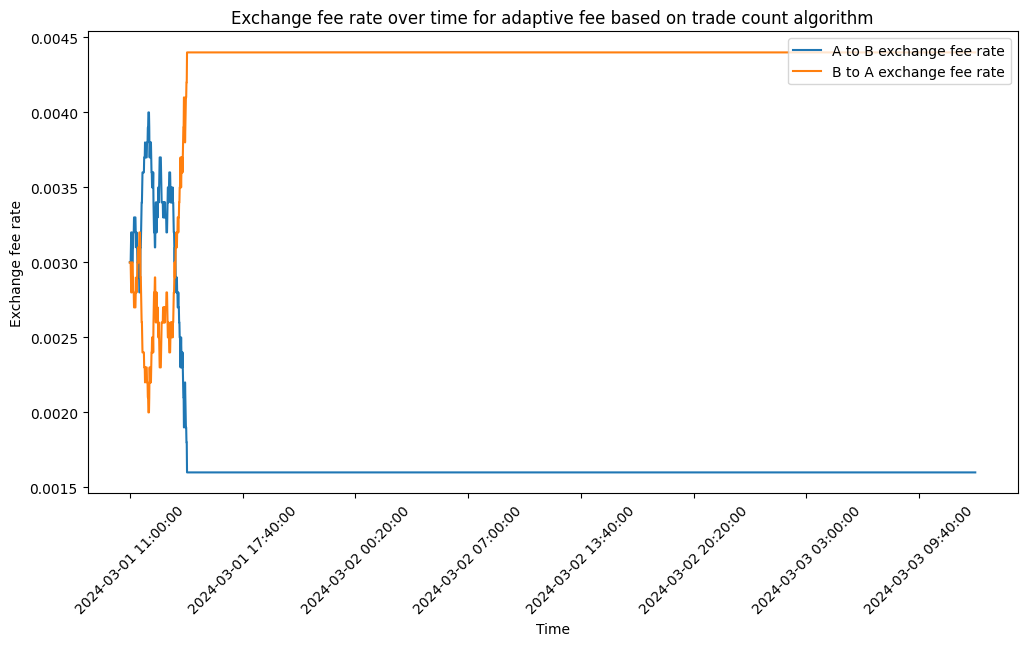

In [18]:
plot_fee_based_on_trade_count_fee_history(
    experiment_results[
        get_experiment_key(
            {
                "period_alias": "volatile_market",
                "fee_algorithm": "based_on_trade_count_fee",
            }
        )
    ],
    "adaptive fee based on trade count",
    3000,
)

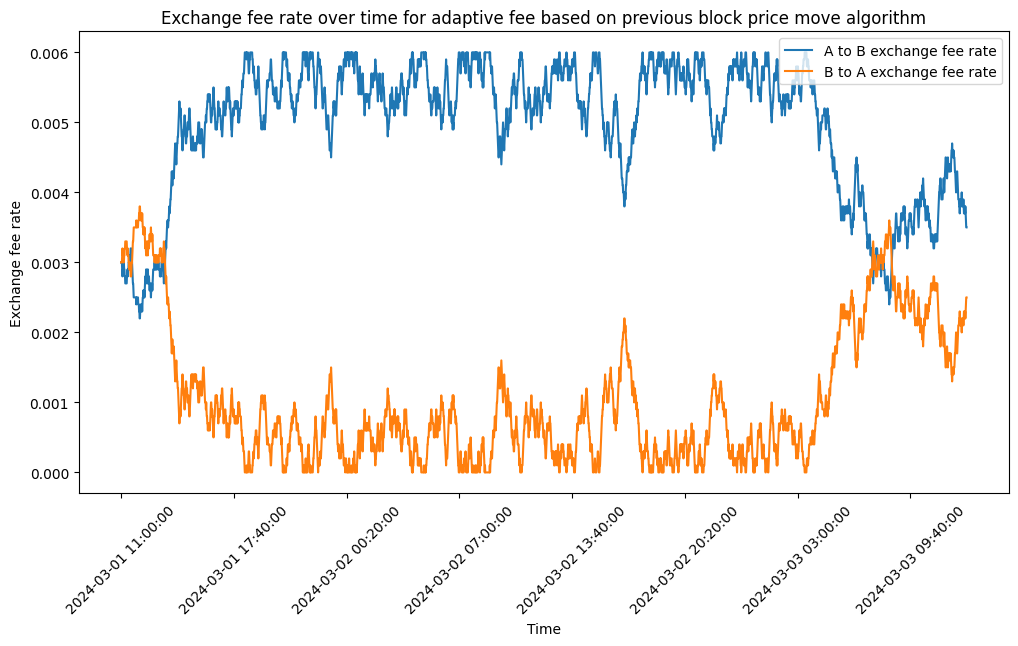

In [19]:
plot_fee_based_on_trade_count_fee_history(
    experiment_results[
        get_experiment_key(
            {
                "period_alias": "volatile_market",
                "fee_algorithm": "adaptive_based_on_previous_block_price_move_fee",
            }
        )
    ],
    "adaptive fee based on previous block price move",
    3000,
)

### Fee based on price ema state

In [20]:
from experiments.experiment import ExperimentResult
from utility import fix_x_axis_labels
from typing import Optional

def plot_fee_algo_price_ema_vs_price(experiment_result: ExperimentResult, first_updates: Optional[int] = None):
    all_snapshots = experiment_result.simulation_result.snapshots
    if first_updates is not None:
        all_snapshots = all_snapshots[:first_updates]

    fee_algo_price_ema = []
    for snapshot in all_snapshots:
        fee_algo_price_ema.append(snapshot.pool.fee_algorithm.a_to_b_price_ema.average())
    
    real_prices = []
    for snapshot in all_snapshots:
        real_prices.append(snapshot.pool.get_a_to_b_exchange_price())
    

    all_timestamps = experiment_result.simulation_result.timestamps
    if first_updates is not None:
        all_timestamps = all_timestamps[:first_updates]

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(all_timestamps, fee_algo_price_ema, label="EMA of price from fee algorithm")
    ax.plot(all_timestamps, real_prices, label="Real price")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Price")
    ax.legend(loc="upper right")
    plt.title("EMA of price from fee algorithm vs real price")

    fix_x_axis_labels(ax)

    plt.xticks(rotation=45)

    plt.show()

In [21]:
# plot_fee_algo_price_ema_vs_price(
#     experiment_results["volatile_market_fee_based_on_historical_price"], first_updates=100
# )